In [1]:
import os
import random
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.parametrizations import spectral_norm
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils

import tqdm
import argparse

In [2]:
import face_recognition

def face_recog(image_dir):
    image_ids = os.listdir(image_dir)
    total_faces = len(image_ids)
    num_faces = 0
    for image_id in image_ids:
        image_path = os.path.join(image_dir, image_id)
        try:
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image, model="HOG")
            if len(face_locations) == 1:
                num_faces += 1
        except:
            total_faces -= 1
    acc = (num_faces / total_faces) * 100
    return acc

In [3]:
import os
import pathlib
import numpy as np
from PIL import Image
from scipy import linalg

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as TF
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d


try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'

class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {64: 0, 192: 1, 768: 2, 2048: 3}

    def __init__(self, output_blocks=(DEFAULT_BLOCK_INDEX,), resize_input=True,
                 normalize_input=True, requires_grad=False, use_fid_inception=True):
       
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(weights=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    inception = _inception_v3(num_classes=1008, aux_logits=False, weights=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


from pytorch_fid.inception import InceptionV3


IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=50, dims=2048, device='cpu', num_workers=1):
    model.eval()
    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=num_workers)

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in dataloader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]
            
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048, device='cpu', num_workers=0):
    act = get_activations(files, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device, num_workers=0):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS for file in path.glob('*.{}'.format(ext))])
        m, s = calculate_activation_statistics(files, model, batch_size, dims, device, num_workers)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims, num_workers=0):
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size, dims, device, num_workers)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size, dims, device, num_workers)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    return fid_value


def fid_value(paths):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    fid_value = calculate_fid_given_paths(paths, 50, device, 2048)
    return fid_value

In [4]:
def normolize(x):
    a, b = x.min(), x.max()
    return (x-a)/(b-a)

def generate_images():
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(100, 100, 1, 1, device=device)
        images = generator(noise).moveaxis(1,3)
        images = normolize(images.cpu().numpy())
    return images

def output_generate_images(output_dir):
    for i in range(10):
        images = generate_images()
        for j in range(100):
            plt.imsave(f'{output_dir}/{str(i*100+j).zfill(4)}.png', images[j])
            
def set_same_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_same_seed(0)

In [5]:
def show_plot(record):
    plt.figure(figsize=(10, 6))
    plt.title("Generator and Discriminator Loss During Training")
    plt.subplot(311)
    plt.plot(record['loss_D'], label='loss_D')
    plt.plot(record['loss_G'], label='loss_G')
    plt.legend()
    plt.grid()
    plt.legend()
    plt.subplot(312)
    plt.plot(record['test_acc'], label='test_acc')
    plt.grid()
    plt.legend()
    plt.subplot(313)
    plt.plot(record['test_fid'], label='test_fid')
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.img_list = [file for file in os.listdir(data_dir) if file.endswith('.png')]
        self.img_list.sort()
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.img_list[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
data_dir = 'D:/NTU/DLCV/hw2/hw2_data/face/train'
image_size = (64, 64)
transform=transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 256

In [8]:
dataset = ImageDataset(data_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

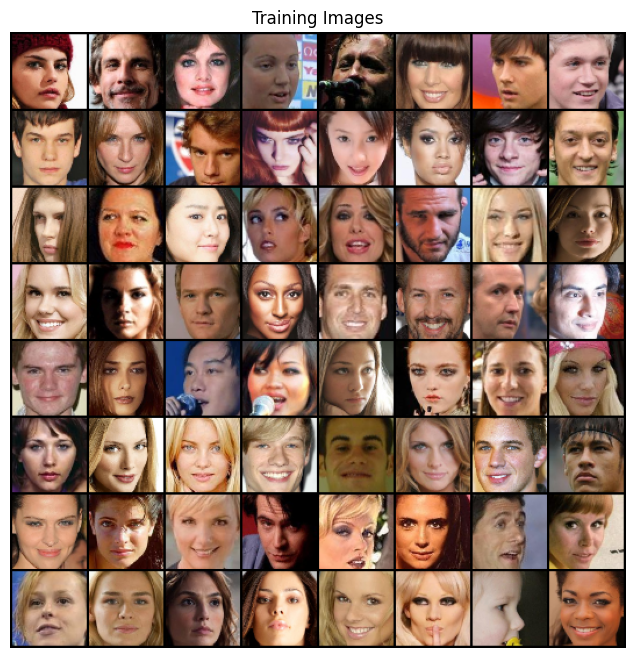

In [9]:
images_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(images_batch[:64], padding=2, normalize=True).moveaxis(0,2))
plt.show()

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='nearest'),
            nn.Conv2d(100, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.PixelShuffle(2),
            nn.Conv2d(32, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.PixelShuffle(2),
            nn.Conv2d(32, 3, 3, padding='same'),
            nn.Tanh()
        )

    def forward(self, X):
        return self.main(X)
    
generator = Generator()
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): Upsample(scale_factor=4.0, mode=nearest)
    (1): Conv2d(100, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): PixelShuffle(upscale_factor=2)
    (6): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): PixelShuffle(upscale_factor=2)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): PixelShuffle(upscale_factor=2)
    (16): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (17): BatchNorm2d(

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
discriminator = Discriminator()
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): ParametrizedConv2d(
      3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ParametrizedConv2d(
      64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ParametrizedConv2d(
      128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# generator = torch.load('v1/generator_600.pth')
# discriminator = torch.load('v1/discriminator_600.pth')

generator = generator.to(device)
discriminator = discriminator.to(device)

record = {'loss_D':[], 'loss_G':[], 'test_acc':[], 'test_fid':[]}
record_load = np.load('DCGAN_v2/record_300.npz')
record['loss_G'] = record_load['loss_G'].tolist()
record['loss_D'] = record_load['loss_D'].tolist()
record['test_acc'] = record_load['test_acc'].tolist()
record['test_fid'] = record_load['test_fid'].tolist()

In [14]:
def make_label(n, label=0, device=device):
    if label==0:
        return torch.rand((n,), dtype=torch.float, device=device)/3
    else:
        return torch.rand((n,), dtype=torch.float, device=device)/3+0.7

In [15]:
# def make_label(n, label=0, device=device):
#     if label==0:
#         return torch.zeros((n,), dtype=torch.float, device=device)
#     else:
#         return torch.ones((n,), dtype=torch.float, device=device)

In [16]:
# noise = torch.randn(128, 100, 1, 1, device=device)
# fake = generator(noise)
# fake.shape

In [17]:
def train_loop():
    
    generator.train()
    discriminator.train()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    step = int(num_batches/10)
    loss_D, loss_G = 0, 0
    
    for batch, data in enumerate(dataloader):
        # train D
        discriminator.zero_grad()
        data = data.to(device)
        b_size = data.size(0)
        label = make_label(b_size, 1)
        output = discriminator(data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        label = make_label(b_size, 0)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        loss_D += errD
        
        # train G
        generator.zero_grad()
        data = data.to(device)
        b_size = data.size(0)
        label = make_label(b_size, 1)
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        loss_G += errG
        
        if batch%step == 0:
            current = (batch+1)*len(data)
            print(f"[{batch:3d}/{num_batches:3d}] loss_D: {errD:.7f}, loss_G: {errG:.7f}, D_x: {D_x:.4f}, D_G_z: {D_G_z1:.4f}/{D_G_z2:.4f}")
        
    loss_D /= num_batches
    loss_G /= num_batches
    
    print(f"Train | loss_D: {loss_D:.8f}, loss_G: {loss_G:.8f}")
    return loss_D, loss_G

In [18]:
# train_loop()

In [19]:
def test_loop(test_dir):
    output_generate_images(test_dir)
    acc = face_recog(test_dir)
    fid = fid_value([test_dir, 'D:/NTU/DLCV/hw2/hw2_data/face/val'])
    print(f"Test  | accuracy: {acc:.2f}%, FID: {fid:.4f}\n")
    return acc, fid

In [21]:
# test_loop('gan_output/')

In [22]:
# show_plot(record)

In [23]:
criterion = nn.BCELoss()

# optimizerD = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerD = optim.SGD(discriminator.parameters(), lr=1e-3, momentum=0.5)
optimizerG = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))

Epoch 1
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.2923163, loss_G: 0.8467205, D_x: 0.5706, D_G_z: 0.4389/0.4359
[ 15/151] loss_D: 0.9772562, loss_G: 1.4527543, D_x: 0.7992, D_G_z: 0.2653/0.2179
[ 30/151] loss_D: 0.9485448, loss_G: 1.4477744, D_x: 0.8043, D_G_z: 0.2228/0.2185
[ 45/151] loss_D: 0.9453721, loss_G: 1.4693522, D_x: 0.8439, D_G_z: 0.2633/0.2130
[ 60/151] loss_D: 0.9503103, loss_G: 1.6297348, D_x: 0.8020, D_G_z: 0.2014/0.1793
[ 75/151] loss_D: 0.9313728, loss_G: 1.5267590, D_x: 0.8038, D_G_z: 0.2205/0.2044
[ 90/151] loss_D: 0.9760064, loss_G: 1.4981277, D_x: 0.7945, D_G_z: 0.2427/0.2016
[105/151] loss_D: 0.9677697, loss_G: 1.5359900, D_x: 0.8041, D_G_z: 0.2180/0.1987
[120/151] loss_D: 0.9633790, loss_G: 1.5209072, D_x: 0.7977, D_G_z: 0.2433/0.1960
[135/151] loss_D: 0.9395705, loss_G: 1.6165377, D_x: 0.7990, D_G_z: 0.2310/0.1761
[150/151] loss_D: 0.9898784, loss_G: 1.3762720, D_x: 0.8174, D_G_z: 0.2624/0.2367
Tr

[105/151] loss_D: 1.0092041, loss_G: 1.2290937, D_x: 0.7334, D_G_z: 0.2765/0.2745
[120/151] loss_D: 0.9893137, loss_G: 1.2668211, D_x: 0.7670, D_G_z: 0.3073/0.2751
[135/151] loss_D: 1.0763702, loss_G: 0.9851872, D_x: 0.6587, D_G_z: 0.2896/0.3673
[150/151] loss_D: 0.9621936, loss_G: 1.1879894, D_x: 0.7118, D_G_z: 0.2740/0.2865
Train | loss_D: 1.01150370, loss_G: 1.25886595
Test  | accuracy: 76.60%, FID: 282.3683

Epoch 9
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0210873, loss_G: 1.2335336, D_x: 0.7544, D_G_z: 0.3279/0.2732
[ 15/151] loss_D: 1.0188875, loss_G: 1.0875925, D_x: 0.7183, D_G_z: 0.3128/0.3229
[ 30/151] loss_D: 1.0052826, loss_G: 1.2973787, D_x: 0.7168, D_G_z: 0.2703/0.2575
[ 45/151] loss_D: 1.0161792, loss_G: 1.2104012, D_x: 0.7069, D_G_z: 0.3134/0.2861
[ 60/151] loss_D: 1.0033838, loss_G: 1.1774633, D_x: 0.7108, D_G_z: 0.2496/0.2858
[ 75/151] loss_D: 1.0798360, loss_G: 1.1443067, D_x: 0.6649, D_G_z: 0.3227/0.3

[ 15/151] loss_D: 1.0789399, loss_G: 1.1369808, D_x: 0.7022, D_G_z: 0.3802/0.3020
[ 30/151] loss_D: 1.0875634, loss_G: 1.0800903, D_x: 0.6867, D_G_z: 0.3660/0.3225
[ 45/151] loss_D: 1.0606338, loss_G: 0.9935586, D_x: 0.6610, D_G_z: 0.3303/0.3498
[ 60/151] loss_D: 1.0724393, loss_G: 1.0520465, D_x: 0.6865, D_G_z: 0.3644/0.3356
[ 75/151] loss_D: 1.1263647, loss_G: 1.1736621, D_x: 0.7207, D_G_z: 0.4356/0.2869
[ 90/151] loss_D: 1.0726757, loss_G: 1.1107248, D_x: 0.7042, D_G_z: 0.3770/0.3129
[105/151] loss_D: 1.0717124, loss_G: 0.9459544, D_x: 0.6374, D_G_z: 0.3152/0.3794
[120/151] loss_D: 1.0988252, loss_G: 0.9435935, D_x: 0.6190, D_G_z: 0.3178/0.3811
[135/151] loss_D: 1.0647547, loss_G: 1.1051519, D_x: 0.6880, D_G_z: 0.3622/0.3137
[150/151] loss_D: 1.1298584, loss_G: 0.9736851, D_x: 0.6244, D_G_z: 0.3513/0.3651
Train | loss_D: 1.08301175, loss_G: 1.04416251
Test  | accuracy: 92.20%, FID: 139.9720

Epoch 17
-----------------------------------------------------------------------------------

[135/151] loss_D: 1.1076243, loss_G: 0.9385034, D_x: 0.6424, D_G_z: 0.3574/0.3781
[150/151] loss_D: 1.1222881, loss_G: 1.0846264, D_x: 0.6582, D_G_z: 0.3608/0.3158
Train | loss_D: 1.11278272, loss_G: 1.00578213
Test  | accuracy: 92.30%, FID: 97.4354

Epoch 24
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0986421, loss_G: 0.8768327, D_x: 0.6405, D_G_z: 0.3411/0.4061
[ 15/151] loss_D: 1.1286125, loss_G: 0.8590952, D_x: 0.6223, D_G_z: 0.3480/0.4165
[ 30/151] loss_D: 1.2863135, loss_G: 1.1795032, D_x: 0.7942, D_G_z: 0.5772/0.2880
[ 45/151] loss_D: 1.1455632, loss_G: 1.0590570, D_x: 0.7066, D_G_z: 0.4592/0.3334
[ 60/151] loss_D: 1.1148956, loss_G: 0.8988804, D_x: 0.6208, D_G_z: 0.3450/0.3993
[ 75/151] loss_D: 1.1174724, loss_G: 1.0196894, D_x: 0.6826, D_G_z: 0.4215/0.3392
[ 90/151] loss_D: 1.0759075, loss_G: 0.9771745, D_x: 0.6716, D_G_z: 0.3745/0.3633
[105/151] loss_D: 1.1140531, loss_G: 0.9832417, D_x: 0.6343, D_G_z: 0.3614/0.3

[ 45/151] loss_D: 1.1090831, loss_G: 0.9218433, D_x: 0.6768, D_G_z: 0.4133/0.3855
[ 60/151] loss_D: 1.0779414, loss_G: 1.0803447, D_x: 0.6801, D_G_z: 0.3690/0.3155
[ 75/151] loss_D: 1.1895124, loss_G: 0.9856485, D_x: 0.6720, D_G_z: 0.4538/0.3558
[ 90/151] loss_D: 1.1436460, loss_G: 0.9186687, D_x: 0.6424, D_G_z: 0.4040/0.3841
[105/151] loss_D: 1.1020281, loss_G: 0.8848307, D_x: 0.5963, D_G_z: 0.3063/0.4018
[120/151] loss_D: 1.1211312, loss_G: 0.8497888, D_x: 0.5850, D_G_z: 0.3119/0.4227
[135/151] loss_D: 1.1295393, loss_G: 0.9169499, D_x: 0.6028, D_G_z: 0.3427/0.3868
[150/151] loss_D: 1.0817044, loss_G: 0.9000151, D_x: 0.6885, D_G_z: 0.3851/0.3967
Train | loss_D: 1.14098549, loss_G: 0.96873951
Test  | accuracy: 93.80%, FID: 68.8579

Epoch 32
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1049871, loss_G: 1.0836962, D_x: 0.6693, D_G_z: 0.3965/0.3203
[ 15/151] loss_D: 1.1282842, loss_G: 0.9916097, D_x: 0.6874, D_G_z: 0.4371/0.3

Test  | accuracy: 95.50%, FID: 62.2046

Epoch 39
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1398277, loss_G: 0.9114604, D_x: 0.6131, D_G_z: 0.3599/0.3915
[ 15/151] loss_D: 1.0940208, loss_G: 0.9122448, D_x: 0.6412, D_G_z: 0.3542/0.3899
[ 30/151] loss_D: 1.1374800, loss_G: 1.0478194, D_x: 0.6901, D_G_z: 0.4406/0.3326
[ 45/151] loss_D: 1.1067097, loss_G: 0.9769456, D_x: 0.6723, D_G_z: 0.4093/0.3608
[ 60/151] loss_D: 1.0597428, loss_G: 1.0381269, D_x: 0.6747, D_G_z: 0.3613/0.3346
[ 75/151] loss_D: 1.1017942, loss_G: 0.7840593, D_x: 0.6174, D_G_z: 0.3181/0.4578
[ 90/151] loss_D: 1.1570566, loss_G: 1.2157009, D_x: 0.7249, D_G_z: 0.4711/0.2703
[105/151] loss_D: 1.1505322, loss_G: 0.8076607, D_x: 0.5592, D_G_z: 0.2901/0.4437
[120/151] loss_D: 1.1145120, loss_G: 1.1245084, D_x: 0.6981, D_G_z: 0.4245/0.3034
[135/151] loss_D: 1.1122417, loss_G: 0.8537824, D_x: 0.6278, D_G_z: 0.3428/0.4194
[150/151] loss_D: 1.1711208, loss_G: 0.8607

[ 90/151] loss_D: 1.0776292, loss_G: 0.9600435, D_x: 0.6773, D_G_z: 0.3798/0.3683
[105/151] loss_D: 1.1531094, loss_G: 0.7437772, D_x: 0.5416, D_G_z: 0.2571/0.4809
[120/151] loss_D: 1.1546726, loss_G: 1.3211979, D_x: 0.6849, D_G_z: 0.4422/0.2440
[135/151] loss_D: 1.1386162, loss_G: 0.9477136, D_x: 0.6572, D_G_z: 0.4095/0.3716
[150/151] loss_D: 1.0983708, loss_G: 0.8871286, D_x: 0.6190, D_G_z: 0.3372/0.4002
Train | loss_D: 1.11825013, loss_G: 0.98984009
Test  | accuracy: 94.40%, FID: 57.9230

Epoch 47
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1424785, loss_G: 1.0320189, D_x: 0.6890, D_G_z: 0.4312/0.3320
[ 15/151] loss_D: 1.0944662, loss_G: 0.9586698, D_x: 0.6595, D_G_z: 0.3799/0.3648
[ 30/151] loss_D: 1.0895572, loss_G: 1.0209970, D_x: 0.6647, D_G_z: 0.3756/0.3391
[ 45/151] loss_D: 1.0938163, loss_G: 0.9169897, D_x: 0.6565, D_G_z: 0.3649/0.3800
[ 60/151] loss_D: 1.0967484, loss_G: 1.0650499, D_x: 0.6725, D_G_z: 0.3897/0.3

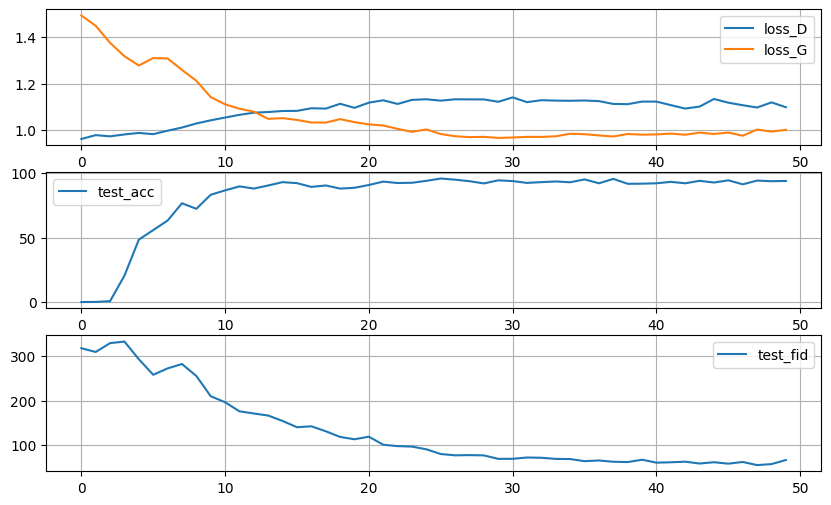

Epoch 51
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1045936, loss_G: 1.3470297, D_x: 0.7673, D_G_z: 0.4662/0.2391
[ 15/151] loss_D: 1.1492161, loss_G: 0.9835436, D_x: 0.6717, D_G_z: 0.4301/0.3588
[ 30/151] loss_D: 1.0374104, loss_G: 1.0942190, D_x: 0.6949, D_G_z: 0.3623/0.3120
[ 45/151] loss_D: 1.0670877, loss_G: 1.1069450, D_x: 0.6716, D_G_z: 0.3611/0.3111
[ 60/151] loss_D: 1.0782441, loss_G: 1.1474526, D_x: 0.7046, D_G_z: 0.3981/0.2969
[ 75/151] loss_D: 1.0781708, loss_G: 1.0784216, D_x: 0.6977, D_G_z: 0.3955/0.3197
[ 90/151] loss_D: 1.0809163, loss_G: 0.8769280, D_x: 0.6530, D_G_z: 0.3449/0.4095
[105/151] loss_D: 1.0884098, loss_G: 0.8852760, D_x: 0.6079, D_G_z: 0.3082/0.4034
[120/151] loss_D: 1.1006255, loss_G: 0.8709043, D_x: 0.6311, D_G_z: 0.3436/0.4100
[135/151] loss_D: 1.0706849, loss_G: 1.0615412, D_x: 0.6965, D_G_z: 0.3858/0.3239
[150/151] loss_D: 1.0815123, loss_G: 1.0315225, D_x: 0.7434, D_G_z: 0.4149/0.3378
T

[105/151] loss_D: 1.1317720, loss_G: 0.9039100, D_x: 0.5645, D_G_z: 0.2635/0.3939
[120/151] loss_D: 1.0812058, loss_G: 1.0133545, D_x: 0.7122, D_G_z: 0.4097/0.3479
[135/151] loss_D: 1.0496581, loss_G: 1.1042116, D_x: 0.7218, D_G_z: 0.3961/0.3081
[150/151] loss_D: 1.1211133, loss_G: 1.2966151, D_x: 0.7300, D_G_z: 0.4151/0.2456
Train | loss_D: 1.08764219, loss_G: 1.02853024
Test  | accuracy: 93.80%, FID: 51.4183

Epoch 59
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1133442, loss_G: 0.8479945, D_x: 0.5842, D_G_z: 0.2783/0.4256
[ 15/151] loss_D: 1.0414077, loss_G: 1.0578634, D_x: 0.6999, D_G_z: 0.3549/0.3279
[ 30/151] loss_D: 1.0389121, loss_G: 1.0110941, D_x: 0.6554, D_G_z: 0.3192/0.3483
[ 45/151] loss_D: 1.0875596, loss_G: 0.8261299, D_x: 0.6217, D_G_z: 0.3034/0.4334
[ 60/151] loss_D: 1.0514652, loss_G: 0.9993801, D_x: 0.7065, D_G_z: 0.3769/0.3539
[ 75/151] loss_D: 1.0616746, loss_G: 1.0196681, D_x: 0.6699, D_G_z: 0.3441/0.3

[ 15/151] loss_D: 1.0709443, loss_G: 1.2593086, D_x: 0.7364, D_G_z: 0.4104/0.2596
[ 30/151] loss_D: 1.0787115, loss_G: 1.2606992, D_x: 0.7380, D_G_z: 0.4086/0.2598
[ 45/151] loss_D: 1.0344727, loss_G: 0.8898546, D_x: 0.6358, D_G_z: 0.2802/0.4001
[ 60/151] loss_D: 1.0337291, loss_G: 1.0038128, D_x: 0.6938, D_G_z: 0.3473/0.3452
[ 75/151] loss_D: 1.0366738, loss_G: 1.2000892, D_x: 0.7482, D_G_z: 0.3945/0.2767
[ 90/151] loss_D: 1.2883272, loss_G: 2.2479548, D_x: 0.8479, D_G_z: 0.5973/0.0855
[105/151] loss_D: 1.1701850, loss_G: 0.9099858, D_x: 0.5962, D_G_z: 0.3630/0.3938
[120/151] loss_D: 1.1242189, loss_G: 0.8248976, D_x: 0.6087, D_G_z: 0.3343/0.4358
[135/151] loss_D: 1.1894534, loss_G: 1.3005595, D_x: 0.8034, D_G_z: 0.5332/0.2503
[150/151] loss_D: 1.1726338, loss_G: 0.8362642, D_x: 0.5573, D_G_z: 0.2933/0.4306
Train | loss_D: 1.10402274, loss_G: 1.02906394
Test  | accuracy: 93.80%, FID: 68.9116

Epoch 67
------------------------------------------------------------------------------------

[135/151] loss_D: 1.0580516, loss_G: 0.7968795, D_x: 0.6037, D_G_z: 0.2428/0.4544
[150/151] loss_D: 1.2591099, loss_G: 0.5454452, D_x: 0.4796, D_G_z: 0.2374/0.6438
Train | loss_D: 1.08824587, loss_G: 1.05827343
Test  | accuracy: 92.70%, FID: 45.5546

Epoch 74
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.4178796, loss_G: 1.7529684, D_x: 0.8269, D_G_z: 0.6582/0.1466
[ 15/151] loss_D: 1.0841762, loss_G: 1.1616483, D_x: 0.6700, D_G_z: 0.3572/0.2949
[ 30/151] loss_D: 1.0645680, loss_G: 1.2379197, D_x: 0.7309, D_G_z: 0.4096/0.2645
[ 45/151] loss_D: 1.0715225, loss_G: 1.0050215, D_x: 0.6045, D_G_z: 0.2510/0.3508
[ 60/151] loss_D: 1.0616832, loss_G: 1.0312964, D_x: 0.6556, D_G_z: 0.3235/0.3387
[ 75/151] loss_D: 1.0380664, loss_G: 1.0301504, D_x: 0.6618, D_G_z: 0.2993/0.3406
[ 90/151] loss_D: 1.0545965, loss_G: 1.2016587, D_x: 0.7488, D_G_z: 0.4057/0.2761
[105/151] loss_D: 1.0072455, loss_G: 1.0767130, D_x: 0.7520, D_G_z: 0.3730/0.3

[ 45/151] loss_D: 0.9956440, loss_G: 1.0627258, D_x: 0.7079, D_G_z: 0.3223/0.3196
[ 60/151] loss_D: 1.0617762, loss_G: 1.2096362, D_x: 0.7398, D_G_z: 0.3949/0.2724
[ 75/151] loss_D: 1.0179927, loss_G: 1.1929883, D_x: 0.7594, D_G_z: 0.3728/0.2781
[ 90/151] loss_D: 0.9907563, loss_G: 1.0322293, D_x: 0.7123, D_G_z: 0.3121/0.3356
[105/151] loss_D: 0.9950565, loss_G: 1.1132977, D_x: 0.7067, D_G_z: 0.3024/0.3023
[120/151] loss_D: 1.0373220, loss_G: 1.2057345, D_x: 0.7329, D_G_z: 0.3764/0.2760
[135/151] loss_D: 1.3139812, loss_G: 1.4168315, D_x: 0.8230, D_G_z: 0.6042/0.2105
[150/151] loss_D: 1.1364880, loss_G: 0.9454440, D_x: 0.6724, D_G_z: 0.3985/0.3638
Train | loss_D: 1.05470014, loss_G: 1.09369218
Test  | accuracy: 93.20%, FID: 45.5199

Epoch 82
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1388950, loss_G: 1.1200233, D_x: 0.6733, D_G_z: 0.4251/0.3031
[ 15/151] loss_D: 1.0433010, loss_G: 1.0463752, D_x: 0.6574, D_G_z: 0.2988/0.3

Test  | accuracy: 93.90%, FID: 47.2227

Epoch 89
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0979874, loss_G: 1.2105789, D_x: 0.8323, D_G_z: 0.4756/0.2670
[ 15/151] loss_D: 1.0274034, loss_G: 1.2411108, D_x: 0.7701, D_G_z: 0.3913/0.2624
[ 30/151] loss_D: 1.0093277, loss_G: 1.0969548, D_x: 0.7332, D_G_z: 0.3510/0.3091
[ 45/151] loss_D: 0.9805050, loss_G: 0.9806272, D_x: 0.6900, D_G_z: 0.2746/0.3533
[ 60/151] loss_D: 0.9897351, loss_G: 1.2634312, D_x: 0.7684, D_G_z: 0.3518/0.2601
[ 75/151] loss_D: 0.9785246, loss_G: 1.1519152, D_x: 0.7171, D_G_z: 0.2981/0.2917
[ 90/151] loss_D: 1.0001588, loss_G: 1.1233253, D_x: 0.7450, D_G_z: 0.3605/0.3027
[105/151] loss_D: 1.0710824, loss_G: 0.8166577, D_x: 0.5775, D_G_z: 0.1848/0.4380
[120/151] loss_D: 0.9800906, loss_G: 1.1037524, D_x: 0.7374, D_G_z: 0.3107/0.3106
[135/151] loss_D: 1.0053403, loss_G: 1.2437931, D_x: 0.7575, D_G_z: 0.3508/0.2614
[150/151] loss_D: 1.2206841, loss_G: 2.3812

[ 90/151] loss_D: 0.9788513, loss_G: 1.1780540, D_x: 0.6868, D_G_z: 0.2770/0.2841
[105/151] loss_D: 1.0200006, loss_G: 1.0013491, D_x: 0.6706, D_G_z: 0.2755/0.3516
[120/151] loss_D: 0.9698770, loss_G: 1.1423731, D_x: 0.7598, D_G_z: 0.3290/0.2942
[135/151] loss_D: 0.9581587, loss_G: 1.1646323, D_x: 0.7119, D_G_z: 0.2585/0.2899
[150/151] loss_D: 1.0384575, loss_G: 0.9208785, D_x: 0.6501, D_G_z: 0.2104/0.3836
Train | loss_D: 1.00150681, loss_G: 1.14711189
Test  | accuracy: 93.10%, FID: 43.4463

Epoch 97
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0228490, loss_G: 1.3080987, D_x: 0.7733, D_G_z: 0.3940/0.2446
[ 15/151] loss_D: 0.9493032, loss_G: 1.3346331, D_x: 0.7666, D_G_z: 0.3235/0.2368
[ 30/151] loss_D: 0.9747981, loss_G: 1.0661089, D_x: 0.7094, D_G_z: 0.2524/0.3259
[ 45/151] loss_D: 0.9560266, loss_G: 1.1731484, D_x: 0.7561, D_G_z: 0.2940/0.2852
[ 60/151] loss_D: 1.1660093, loss_G: 0.9389862, D_x: 0.6616, D_G_z: 0.4490/0.3

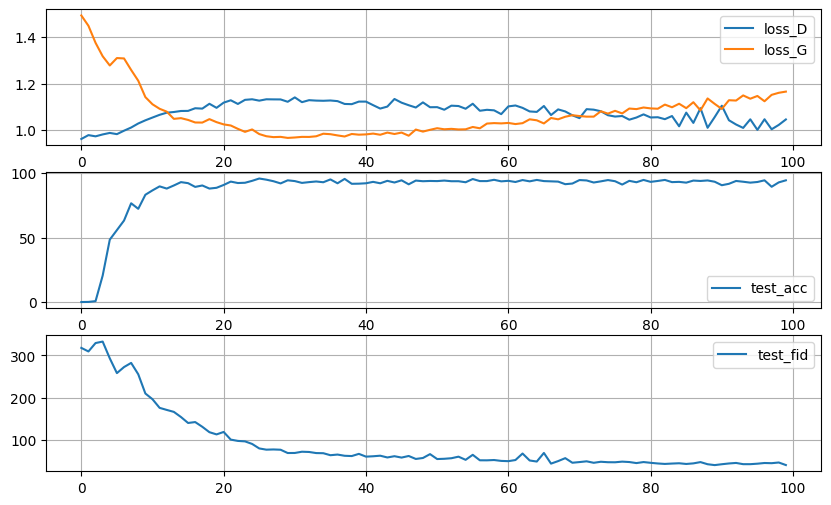

Epoch 101
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9942657, loss_G: 1.3844359, D_x: 0.7971, D_G_z: 0.3874/0.2199
[ 15/151] loss_D: 0.9941736, loss_G: 1.1296763, D_x: 0.7409, D_G_z: 0.3336/0.3015
[ 30/151] loss_D: 0.9694915, loss_G: 1.2462249, D_x: 0.7302, D_G_z: 0.3064/0.2611
[ 45/151] loss_D: 0.9608777, loss_G: 1.1957313, D_x: 0.7739, D_G_z: 0.3200/0.2773
[ 60/151] loss_D: 1.0001512, loss_G: 1.0761428, D_x: 0.6710, D_G_z: 0.2583/0.3224
[ 75/151] loss_D: 0.9871396, loss_G: 1.2731932, D_x: 0.7523, D_G_z: 0.3367/0.2516
[ 90/151] loss_D: 0.9836319, loss_G: 1.2835326, D_x: 0.7640, D_G_z: 0.3470/0.2521
[105/151] loss_D: 1.1921873, loss_G: 0.7865018, D_x: 0.5674, D_G_z: 0.3573/0.4570
[120/151] loss_D: 1.0311067, loss_G: 1.1548629, D_x: 0.6774, D_G_z: 0.2927/0.2911
[135/151] loss_D: 0.9664079, loss_G: 1.2108073, D_x: 0.7583, D_G_z: 0.3121/0.2710
[150/151] loss_D: 1.0439928, loss_G: 1.2449784, D_x: 0.7120, D_G_z: 0.3666/0.2692


[ 90/151] loss_D: 0.9619316, loss_G: 1.1808136, D_x: 0.7502, D_G_z: 0.3159/0.2850
[105/151] loss_D: 1.1523111, loss_G: 0.8731760, D_x: 0.7311, D_G_z: 0.4762/0.4113
[120/151] loss_D: 1.0775336, loss_G: 0.9300311, D_x: 0.5853, D_G_z: 0.2241/0.3844
[135/151] loss_D: 0.9907546, loss_G: 1.0664132, D_x: 0.7346, D_G_z: 0.3003/0.3244
[150/151] loss_D: 1.0300193, loss_G: 1.1256094, D_x: 0.7689, D_G_z: 0.3331/0.3080
Train | loss_D: 1.01117969, loss_G: 1.17572832
Test  | accuracy: 93.10%, FID: 43.3183

Epoch 109
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9452552, loss_G: 1.3259370, D_x: 0.7677, D_G_z: 0.2978/0.2390
[ 15/151] loss_D: 0.9510903, loss_G: 1.3473223, D_x: 0.7403, D_G_z: 0.2885/0.2311
[ 30/151] loss_D: 0.9854665, loss_G: 1.0251044, D_x: 0.6509, D_G_z: 0.2034/0.3370
[ 45/151] loss_D: 1.0160995, loss_G: 0.9042673, D_x: 0.6211, D_G_z: 0.1703/0.4006
[ 60/151] loss_D: 0.9730459, loss_G: 1.3280581, D_x: 0.7695, D_G_z: 0.2913/0.

[  0/151] loss_D: 0.9534903, loss_G: 1.2859174, D_x: 0.7832, D_G_z: 0.3438/0.2494
[ 15/151] loss_D: 1.2006371, loss_G: 0.8507079, D_x: 0.4859, D_G_z: 0.1879/0.4203
[ 30/151] loss_D: 1.0242612, loss_G: 1.3982419, D_x: 0.7477, D_G_z: 0.3732/0.2209
[ 45/151] loss_D: 0.9470030, loss_G: 1.2338219, D_x: 0.7261, D_G_z: 0.2405/0.2691
[ 60/151] loss_D: 0.9533001, loss_G: 1.3475798, D_x: 0.7909, D_G_z: 0.3483/0.2331
[ 75/151] loss_D: 0.9865165, loss_G: 0.9830810, D_x: 0.6995, D_G_z: 0.2442/0.3565
[ 90/151] loss_D: 0.9833887, loss_G: 1.2609568, D_x: 0.7170, D_G_z: 0.2841/0.2592
[105/151] loss_D: 0.9419965, loss_G: 1.3903027, D_x: 0.7839, D_G_z: 0.2958/0.2256
[120/151] loss_D: 0.9337830, loss_G: 1.5046065, D_x: 0.7949, D_G_z: 0.3086/0.1917
[135/151] loss_D: 0.9665529, loss_G: 1.3446867, D_x: 0.8023, D_G_z: 0.3555/0.2341
[150/151] loss_D: 1.4988952, loss_G: 0.5072418, D_x: 0.3224, D_G_z: 0.1376/0.6679
Train | loss_D: 0.99507391, loss_G: 1.22530913
Test  | accuracy: 92.40%, FID: 42.1846

Epoch 117
-

[120/151] loss_D: 0.9795690, loss_G: 1.4264529, D_x: 0.8263, D_G_z: 0.3467/0.2136
[135/151] loss_D: 0.9419335, loss_G: 1.1879150, D_x: 0.7711, D_G_z: 0.2840/0.2797
[150/151] loss_D: 0.9885442, loss_G: 0.8708488, D_x: 0.6818, D_G_z: 0.2173/0.4083
Train | loss_D: 0.96896303, loss_G: 1.23139262
Test  | accuracy: 90.90%, FID: 39.5286

Epoch 124
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0073137, loss_G: 1.5349715, D_x: 0.8191, D_G_z: 0.3958/0.1908
[ 15/151] loss_D: 0.9414979, loss_G: 1.0818081, D_x: 0.7486, D_G_z: 0.2768/0.3204
[ 30/151] loss_D: 1.8829503, loss_G: 0.5392185, D_x: 0.2340, D_G_z: 0.0734/0.6479
[ 45/151] loss_D: 1.0334086, loss_G: 1.4438161, D_x: 0.7750, D_G_z: 0.4017/0.2092
[ 60/151] loss_D: 0.9596072, loss_G: 1.2357512, D_x: 0.7052, D_G_z: 0.2163/0.2640
[ 75/151] loss_D: 0.9243405, loss_G: 1.0484173, D_x: 0.7076, D_G_z: 0.2029/0.3340
[ 90/151] loss_D: 0.9640157, loss_G: 1.1173027, D_x: 0.7066, D_G_z: 0.2371/0.

[ 30/151] loss_D: 1.1067719, loss_G: 1.7009790, D_x: 0.9108, D_G_z: 0.4776/0.1571
[ 45/151] loss_D: 1.6821786, loss_G: 2.6936293, D_x: 0.9602, D_G_z: 0.7239/0.0544
[ 60/151] loss_D: 1.0274030, loss_G: 1.0204427, D_x: 0.6663, D_G_z: 0.2900/0.3424
[ 75/151] loss_D: 0.9367356, loss_G: 1.6964492, D_x: 0.8092, D_G_z: 0.3156/0.1566
[ 90/151] loss_D: 0.9462270, loss_G: 1.0789831, D_x: 0.7327, D_G_z: 0.2581/0.3186
[105/151] loss_D: 1.0396357, loss_G: 1.2483337, D_x: 0.8023, D_G_z: 0.4289/0.2673
[120/151] loss_D: 1.0060573, loss_G: 1.5794488, D_x: 0.8087, D_G_z: 0.3933/0.1802
[135/151] loss_D: 0.9668624, loss_G: 1.1157554, D_x: 0.6683, D_G_z: 0.2070/0.3053
[150/151] loss_D: 0.9620268, loss_G: 0.9335788, D_x: 0.6624, D_G_z: 0.1602/0.3848
Train | loss_D: 1.00761807, loss_G: 1.26398635
Test  | accuracy: 93.00%, FID: 45.8917

Epoch 132
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0135556, loss_G: 1.4687351, D_x: 0.8538, D_G_z: 0.3923/0.

[150/151] loss_D: 0.9846448, loss_G: 0.9896669, D_x: 0.6656, D_G_z: 0.2309/0.3558
Train | loss_D: 1.01927722, loss_G: 1.25798476
Test  | accuracy: 92.90%, FID: 41.4281

Epoch 139
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9760401, loss_G: 1.5657281, D_x: 0.8271, D_G_z: 0.3774/0.1809
[ 15/151] loss_D: 0.9138385, loss_G: 1.3080430, D_x: 0.7731, D_G_z: 0.2384/0.2398
[ 30/151] loss_D: 0.9245446, loss_G: 1.1958065, D_x: 0.7693, D_G_z: 0.2758/0.2781
[ 45/151] loss_D: 0.9317359, loss_G: 1.2021148, D_x: 0.7573, D_G_z: 0.2761/0.2744
[ 60/151] loss_D: 0.9228498, loss_G: 1.6124568, D_x: 0.8171, D_G_z: 0.3000/0.1714
[ 75/151] loss_D: 0.9556171, loss_G: 1.1953702, D_x: 0.7006, D_G_z: 0.1828/0.2791
[ 90/151] loss_D: 0.9055260, loss_G: 1.1812487, D_x: 0.7741, D_G_z: 0.2492/0.2855
[105/151] loss_D: 0.9971266, loss_G: 1.1458681, D_x: 0.7266, D_G_z: 0.3303/0.2946
[120/151] loss_D: 1.0686111, loss_G: 0.7602125, D_x: 0.5780, D_G_z: 0.1518/0.

[ 60/151] loss_D: 0.8963559, loss_G: 1.3579311, D_x: 0.8047, D_G_z: 0.2505/0.2285
[ 75/151] loss_D: 0.9649929, loss_G: 1.1131816, D_x: 0.6750, D_G_z: 0.1935/0.3074
[ 90/151] loss_D: 0.8751341, loss_G: 1.4867550, D_x: 0.7971, D_G_z: 0.2089/0.1963
[105/151] loss_D: 0.9413205, loss_G: 1.3946627, D_x: 0.7646, D_G_z: 0.3077/0.2218
[120/151] loss_D: 0.9042376, loss_G: 1.4126611, D_x: 0.7877, D_G_z: 0.2546/0.2181
[135/151] loss_D: 0.9563930, loss_G: 0.9345514, D_x: 0.7012, D_G_z: 0.2541/0.3814
[150/151] loss_D: 0.9122823, loss_G: 1.5060052, D_x: 0.8052, D_G_z: 0.2321/0.1909
Train | loss_D: 0.97364676, loss_G: 1.29562271
Test  | accuracy: 92.60%, FID: 41.0804

Epoch 147
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8953009, loss_G: 1.1698766, D_x: 0.7626, D_G_z: 0.2214/0.2865
[ 15/151] loss_D: 0.9040329, loss_G: 1.2619082, D_x: 0.7987, D_G_z: 0.2516/0.2646
[ 30/151] loss_D: 0.9086777, loss_G: 1.6322765, D_x: 0.8664, D_G_z: 0.3069/0.

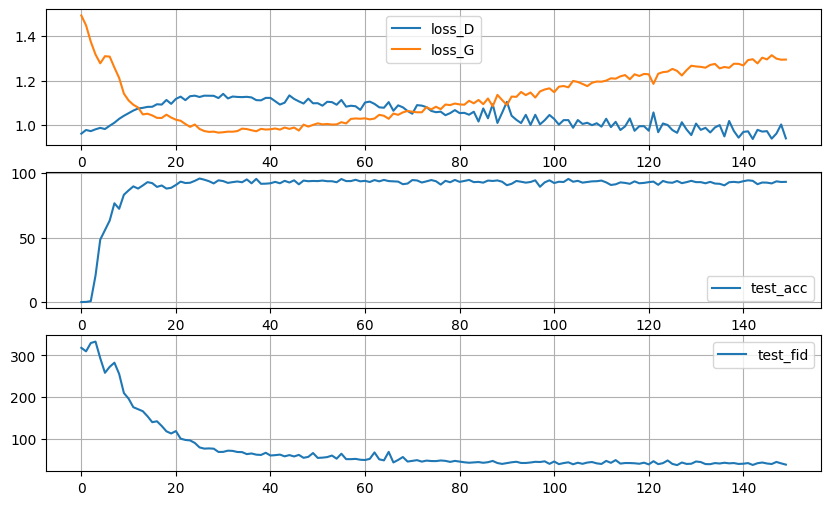

Epoch 151
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9813461, loss_G: 1.9507940, D_x: 0.8444, D_G_z: 0.3909/0.1183
[ 15/151] loss_D: 1.1322144, loss_G: 2.0791492, D_x: 0.8203, D_G_z: 0.5106/0.0991
[ 30/151] loss_D: 0.9277426, loss_G: 1.0989753, D_x: 0.7535, D_G_z: 0.2418/0.3102
[ 45/151] loss_D: 0.9753177, loss_G: 1.1605864, D_x: 0.6750, D_G_z: 0.1812/0.2863
[ 60/151] loss_D: 0.9459455, loss_G: 1.3005606, D_x: 0.7913, D_G_z: 0.3069/0.2481
[ 75/151] loss_D: 0.9224117, loss_G: 1.3485882, D_x: 0.7853, D_G_z: 0.2822/0.2295
[ 90/151] loss_D: 0.9149897, loss_G: 1.2372179, D_x: 0.7727, D_G_z: 0.2658/0.2612
[105/151] loss_D: 0.9180304, loss_G: 1.5279514, D_x: 0.8781, D_G_z: 0.3182/0.1879
[120/151] loss_D: 0.9143587, loss_G: 1.4107437, D_x: 0.7938, D_G_z: 0.2611/0.2146
[135/151] loss_D: 0.9189255, loss_G: 1.3583243, D_x: 0.8258, D_G_z: 0.2648/0.2300
[150/151] loss_D: 0.9167467, loss_G: 1.2686527, D_x: 0.7482, D_G_z: 0.2337/0.2499


[ 90/151] loss_D: 0.9295590, loss_G: 1.1664004, D_x: 0.7365, D_G_z: 0.2548/0.2874
[105/151] loss_D: 0.9234892, loss_G: 1.2259586, D_x: 0.8099, D_G_z: 0.2854/0.2670
[120/151] loss_D: 0.9236159, loss_G: 1.2891384, D_x: 0.7599, D_G_z: 0.2181/0.2510
[135/151] loss_D: 0.9039211, loss_G: 1.5231149, D_x: 0.8209, D_G_z: 0.2715/0.1889
[150/151] loss_D: 1.0147867, loss_G: 0.8608190, D_x: 0.6440, D_G_z: 0.1469/0.4072
Train | loss_D: 0.92121696, loss_G: 1.32952321
Test  | accuracy: 93.70%, FID: 42.6120

Epoch 159
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0792650, loss_G: 1.8164394, D_x: 0.8922, D_G_z: 0.4722/0.1396
[ 15/151] loss_D: 1.1058443, loss_G: 0.7853962, D_x: 0.5630, D_G_z: 0.2065/0.4570
[ 30/151] loss_D: 0.9925781, loss_G: 1.2428169, D_x: 0.6795, D_G_z: 0.2449/0.2674
[ 45/151] loss_D: 0.9331198, loss_G: 1.1900783, D_x: 0.7841, D_G_z: 0.3041/0.2795
[ 60/151] loss_D: 0.9724932, loss_G: 1.3464929, D_x: 0.8415, D_G_z: 0.3562/0.

[  0/151] loss_D: 0.9979567, loss_G: 1.3299359, D_x: 0.8569, D_G_z: 0.3815/0.2429
[ 15/151] loss_D: 0.9352784, loss_G: 1.7412782, D_x: 0.8433, D_G_z: 0.3220/0.1444
[ 30/151] loss_D: 0.9412665, loss_G: 1.2938685, D_x: 0.7930, D_G_z: 0.2738/0.2466
[ 45/151] loss_D: 0.9890794, loss_G: 1.1152669, D_x: 0.6732, D_G_z: 0.2652/0.3045
[ 60/151] loss_D: 1.0198126, loss_G: 1.0529759, D_x: 0.6283, D_G_z: 0.1496/0.3334
[ 75/151] loss_D: 0.9075449, loss_G: 1.6693577, D_x: 0.8610, D_G_z: 0.3263/0.1618
[ 90/151] loss_D: 0.8825081, loss_G: 1.2920742, D_x: 0.7731, D_G_z: 0.2026/0.2505
[105/151] loss_D: 0.9126269, loss_G: 1.4347785, D_x: 0.8407, D_G_z: 0.2989/0.2097
[120/151] loss_D: 0.9011099, loss_G: 1.3451331, D_x: 0.7824, D_G_z: 0.2256/0.2273
[135/151] loss_D: 0.8998412, loss_G: 1.3751935, D_x: 0.8207, D_G_z: 0.2839/0.2253
[150/151] loss_D: 0.9087450, loss_G: 1.4437571, D_x: 0.7483, D_G_z: 0.1725/0.2146
Train | loss_D: 0.92938960, loss_G: 1.34287727
Test  | accuracy: 93.80%, FID: 38.6614

Epoch 167
-

[120/151] loss_D: 2.3267577, loss_G: 0.4100937, D_x: 0.1679, D_G_z: 0.0309/0.8737
[135/151] loss_D: 1.1789987, loss_G: 0.6633732, D_x: 0.5109, D_G_z: 0.2232/0.5420
[150/151] loss_D: 1.0781050, loss_G: 0.7452611, D_x: 0.5568, D_G_z: 0.1948/0.4795
Train | loss_D: 0.98299676, loss_G: 1.33447492
Test  | accuracy: 94.60%, FID: 44.7171

Epoch 174
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.1917765, loss_G: 2.0053179, D_x: 0.8978, D_G_z: 0.5550/0.1120
[ 15/151] loss_D: 0.9407348, loss_G: 1.3360929, D_x: 0.7282, D_G_z: 0.2566/0.2352
[ 30/151] loss_D: 0.9168849, loss_G: 1.1367667, D_x: 0.8118, D_G_z: 0.2598/0.3026
[ 45/151] loss_D: 0.9245936, loss_G: 1.6405493, D_x: 0.8092, D_G_z: 0.3050/0.1667
[ 60/151] loss_D: 0.9286612, loss_G: 1.2178482, D_x: 0.7580, D_G_z: 0.2003/0.2684
[ 75/151] loss_D: 0.9252154, loss_G: 1.7633858, D_x: 0.8737, D_G_z: 0.3278/0.1414
[ 90/151] loss_D: 0.8830556, loss_G: 1.3624520, D_x: 0.8178, D_G_z: 0.2392/0.

[ 30/151] loss_D: 0.9106029, loss_G: 1.1352744, D_x: 0.7394, D_G_z: 0.2277/0.2978
[ 45/151] loss_D: 0.9637173, loss_G: 0.9371473, D_x: 0.6660, D_G_z: 0.1450/0.3760
[ 60/151] loss_D: 0.9295131, loss_G: 1.1460241, D_x: 0.7262, D_G_z: 0.1669/0.2896
[ 75/151] loss_D: 0.9238970, loss_G: 1.0428419, D_x: 0.7589, D_G_z: 0.1947/0.3287
[ 90/151] loss_D: 0.8980041, loss_G: 1.3211694, D_x: 0.7609, D_G_z: 0.2348/0.2399
[105/151] loss_D: 1.0380466, loss_G: 2.0012078, D_x: 0.8816, D_G_z: 0.4470/0.1109
[120/151] loss_D: 0.9007324, loss_G: 1.4443085, D_x: 0.8630, D_G_z: 0.2797/0.2054
[135/151] loss_D: 0.9378371, loss_G: 1.2788671, D_x: 0.7124, D_G_z: 0.1928/0.2482
[150/151] loss_D: 0.9025249, loss_G: 1.2250255, D_x: 0.7614, D_G_z: 0.2251/0.2770
Train | loss_D: 0.92497736, loss_G: 1.36436594
Test  | accuracy: 91.60%, FID: 40.1725

Epoch 182
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9235545, loss_G: 1.4900150, D_x: 0.8218, D_G_z: 0.2958/0.

[150/151] loss_D: 0.9084523, loss_G: 1.3847663, D_x: 0.8013, D_G_z: 0.1900/0.2231
Train | loss_D: 0.93750769, loss_G: 1.37774634
Test  | accuracy: 89.90%, FID: 39.3725

Epoch 189
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8944875, loss_G: 1.2278429, D_x: 0.7933, D_G_z: 0.2423/0.2683
[ 15/151] loss_D: 0.8771892, loss_G: 1.6421628, D_x: 0.8539, D_G_z: 0.2104/0.1643
[ 30/151] loss_D: 0.8863925, loss_G: 1.5174508, D_x: 0.8768, D_G_z: 0.2724/0.1923
[ 45/151] loss_D: 0.9450339, loss_G: 1.7831737, D_x: 0.8690, D_G_z: 0.3565/0.1385
[ 60/151] loss_D: 0.9364566, loss_G: 1.1744347, D_x: 0.7523, D_G_z: 0.1313/0.2886
[ 75/151] loss_D: 0.8907111, loss_G: 1.3505006, D_x: 0.8217, D_G_z: 0.2293/0.2326
[ 90/151] loss_D: 1.2625902, loss_G: 1.9884748, D_x: 0.9195, D_G_z: 0.5742/0.1114
[105/151] loss_D: 0.9724230, loss_G: 1.1794031, D_x: 0.7429, D_G_z: 0.2931/0.2827
[120/151] loss_D: 0.9754117, loss_G: 1.0976207, D_x: 0.6666, D_G_z: 0.1402/0.

[ 60/151] loss_D: 0.8774860, loss_G: 1.2973311, D_x: 0.7646, D_G_z: 0.1715/0.2422
[ 75/151] loss_D: 0.9371489, loss_G: 1.2940682, D_x: 0.8308, D_G_z: 0.3141/0.2419
[ 90/151] loss_D: 0.8853856, loss_G: 1.5857623, D_x: 0.8472, D_G_z: 0.2119/0.1747
[105/151] loss_D: 1.1913736, loss_G: 0.9724779, D_x: 0.5295, D_G_z: 0.0671/0.3605
[120/151] loss_D: 0.9286838, loss_G: 1.7488587, D_x: 0.8829, D_G_z: 0.2896/0.1439
[135/151] loss_D: 0.8763884, loss_G: 1.8635241, D_x: 0.8620, D_G_z: 0.2491/0.1277
[150/151] loss_D: 0.9009526, loss_G: 1.2915990, D_x: 0.7691, D_G_z: 0.2566/0.2454
Train | loss_D: 0.92823690, loss_G: 1.45592964
Test  | accuracy: 92.60%, FID: 43.3346

Epoch 197
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9226403, loss_G: 1.7304289, D_x: 0.8788, D_G_z: 0.2934/0.1482
[ 15/151] loss_D: 1.0060630, loss_G: 1.1917037, D_x: 0.6662, D_G_z: 0.1338/0.2800
[ 30/151] loss_D: 0.9438858, loss_G: 1.4636860, D_x: 0.7515, D_G_z: 0.1811/0.

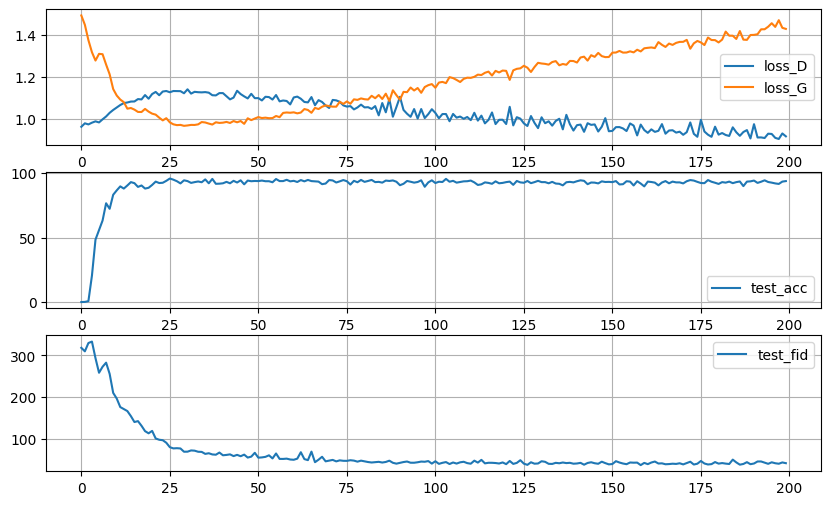

Epoch 201
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9289126, loss_G: 1.6144137, D_x: 0.8701, D_G_z: 0.2899/0.1730
[ 15/151] loss_D: 0.9403765, loss_G: 1.7866584, D_x: 0.8895, D_G_z: 0.3199/0.1406
[ 30/151] loss_D: 0.8726001, loss_G: 1.5643680, D_x: 0.8653, D_G_z: 0.2236/0.1755
[ 45/151] loss_D: 1.7916692, loss_G: 0.6308975, D_x: 0.2870, D_G_z: 0.0379/0.5589
[ 60/151] loss_D: 0.8722528, loss_G: 1.4026916, D_x: 0.8114, D_G_z: 0.1862/0.2176
[ 75/151] loss_D: 0.9307489, loss_G: 1.7432985, D_x: 0.8764, D_G_z: 0.3092/0.1464
[ 90/151] loss_D: 0.9109287, loss_G: 1.8227983, D_x: 0.8724, D_G_z: 0.2836/0.1356
[105/151] loss_D: 0.9606180, loss_G: 1.7373757, D_x: 0.8729, D_G_z: 0.3616/0.1428
[120/151] loss_D: 0.8931463, loss_G: 1.4910438, D_x: 0.8230, D_G_z: 0.2280/0.1944
[135/151] loss_D: 0.9039174, loss_G: 1.3901029, D_x: 0.8056, D_G_z: 0.1929/0.2210
[150/151] loss_D: 0.8878320, loss_G: 1.4739670, D_x: 0.8571, D_G_z: 0.2358/0.2029


[ 90/151] loss_D: 0.9404111, loss_G: 1.2619023, D_x: 0.7141, D_G_z: 0.1719/0.2496
[105/151] loss_D: 0.8799157, loss_G: 1.4777744, D_x: 0.7758, D_G_z: 0.1313/0.1974
[120/151] loss_D: 0.9410810, loss_G: 1.6239958, D_x: 0.8209, D_G_z: 0.3111/0.1641
[135/151] loss_D: 0.8676636, loss_G: 1.7174056, D_x: 0.8217, D_G_z: 0.1893/0.1527
[150/151] loss_D: 0.8931919, loss_G: 1.5001575, D_x: 0.8200, D_G_z: 0.1945/0.1964
Train | loss_D: 0.91569197, loss_G: 1.44167852
Test  | accuracy: 92.40%, FID: 38.9001

Epoch 209
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9065701, loss_G: 1.4003816, D_x: 0.7478, D_G_z: 0.2016/0.2175
[ 15/151] loss_D: 0.8987623, loss_G: 1.0727689, D_x: 0.7608, D_G_z: 0.1809/0.3211
[ 30/151] loss_D: 0.8889731, loss_G: 1.4469910, D_x: 0.8106, D_G_z: 0.2247/0.2011
[ 45/151] loss_D: 0.8861972, loss_G: 1.4277430, D_x: 0.7836, D_G_z: 0.1905/0.2116
[ 60/151] loss_D: 0.8922257, loss_G: 1.2279785, D_x: 0.8088, D_G_z: 0.2316/0.

[  0/151] loss_D: 0.8895366, loss_G: 1.5271459, D_x: 0.8431, D_G_z: 0.2754/0.1850
[ 15/151] loss_D: 0.9199485, loss_G: 1.2671974, D_x: 0.7450, D_G_z: 0.1514/0.2533
[ 30/151] loss_D: 0.8781961, loss_G: 1.1657557, D_x: 0.7825, D_G_z: 0.1660/0.2880
[ 45/151] loss_D: 0.8755125, loss_G: 1.6765049, D_x: 0.8824, D_G_z: 0.2145/0.1571
[ 60/151] loss_D: 0.8976047, loss_G: 1.3332350, D_x: 0.7896, D_G_z: 0.1318/0.2368
[ 75/151] loss_D: 0.9976919, loss_G: 1.0803380, D_x: 0.6564, D_G_z: 0.1141/0.3170
[ 90/151] loss_D: 0.9451400, loss_G: 1.6791505, D_x: 0.8957, D_G_z: 0.3363/0.1541
[105/151] loss_D: 0.8900763, loss_G: 1.5301936, D_x: 0.8429, D_G_z: 0.2409/0.1822
[120/151] loss_D: 0.9031909, loss_G: 1.7080971, D_x: 0.8620, D_G_z: 0.2243/0.1502
[135/151] loss_D: 0.9353738, loss_G: 1.9588449, D_x: 0.8880, D_G_z: 0.3532/0.1178
[150/151] loss_D: 0.8383536, loss_G: 2.1635809, D_x: 0.8945, D_G_z: 0.1877/0.0910
Train | loss_D: 0.89933729, loss_G: 1.44857478
Test  | accuracy: 93.70%, FID: 37.1944

Epoch 217
-

[120/151] loss_D: 0.9395477, loss_G: 1.8041003, D_x: 0.8598, D_G_z: 0.3428/0.1391
[135/151] loss_D: 0.8852417, loss_G: 1.6442699, D_x: 0.8272, D_G_z: 0.2536/0.1636
[150/151] loss_D: 0.9282178, loss_G: 1.6641550, D_x: 0.8883, D_G_z: 0.3358/0.1503
Train | loss_D: 0.90448058, loss_G: 1.44371068
Test  | accuracy: 93.20%, FID: 45.3985

Epoch 224
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8920289, loss_G: 1.2784605, D_x: 0.7882, D_G_z: 0.1655/0.2509
[ 15/151] loss_D: 0.8879442, loss_G: 1.6899201, D_x: 0.9010, D_G_z: 0.2756/0.1527
[ 30/151] loss_D: 0.8460891, loss_G: 1.6437846, D_x: 0.8789, D_G_z: 0.2096/0.1607
[ 45/151] loss_D: 0.9419386, loss_G: 1.6720722, D_x: 0.7742, D_G_z: 0.2824/0.1627
[ 60/151] loss_D: 0.9684795, loss_G: 2.0901299, D_x: 0.9274, D_G_z: 0.3255/0.1005
[ 75/151] loss_D: 1.9425867, loss_G: 0.4243255, D_x: 0.2432, D_G_z: 0.0297/0.8422
[ 90/151] loss_D: 0.9378614, loss_G: 1.4192579, D_x: 0.8158, D_G_z: 0.3019/0.

[ 30/151] loss_D: 0.8475977, loss_G: 1.6894772, D_x: 0.8677, D_G_z: 0.2084/0.1542
[ 45/151] loss_D: 0.8752159, loss_G: 1.4493179, D_x: 0.7935, D_G_z: 0.2222/0.2091
[ 60/151] loss_D: 0.8907330, loss_G: 1.2429633, D_x: 0.7878, D_G_z: 0.1668/0.2612
[ 75/151] loss_D: 0.8732445, loss_G: 1.6230102, D_x: 0.8272, D_G_z: 0.2091/0.1648
[ 90/151] loss_D: 0.8853557, loss_G: 1.6919554, D_x: 0.8844, D_G_z: 0.2791/0.1542
[105/151] loss_D: 0.9014455, loss_G: 1.7920719, D_x: 0.8980, D_G_z: 0.3084/0.1369
[120/151] loss_D: 0.8784626, loss_G: 1.4604437, D_x: 0.8400, D_G_z: 0.2024/0.1969
[135/151] loss_D: 0.8517466, loss_G: 1.5182400, D_x: 0.8244, D_G_z: 0.1635/0.1882
[150/151] loss_D: 0.9036409, loss_G: 1.2373962, D_x: 0.7630, D_G_z: 0.1624/0.2648
Train | loss_D: 0.89321083, loss_G: 1.46906388
Test  | accuracy: 94.70%, FID: 40.2144

Epoch 232
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9006854, loss_G: 1.4722866, D_x: 0.8291, D_G_z: 0.2850/0.

[150/151] loss_D: 0.9499147, loss_G: 0.8829954, D_x: 0.6965, D_G_z: 0.1348/0.3986
Train | loss_D: 0.91739517, loss_G: 1.49105108
Test  | accuracy: 91.40%, FID: 43.5253

Epoch 239
---------------------------------------------------------------------------------------
[  0/151] loss_D: 1.0227488, loss_G: 1.8988955, D_x: 0.9063, D_G_z: 0.4199/0.1207
[ 15/151] loss_D: 0.8826376, loss_G: 1.7679225, D_x: 0.8798, D_G_z: 0.2444/0.1420
[ 30/151] loss_D: 0.8564544, loss_G: 1.5830320, D_x: 0.8140, D_G_z: 0.1489/0.1753
[ 45/151] loss_D: 0.8840467, loss_G: 1.1518779, D_x: 0.7744, D_G_z: 0.1600/0.2921
[ 60/151] loss_D: 0.8534913, loss_G: 1.4894383, D_x: 0.7939, D_G_z: 0.1211/0.1976
[ 75/151] loss_D: 0.9391193, loss_G: 1.8134580, D_x: 0.8628, D_G_z: 0.3337/0.1293
[ 90/151] loss_D: 0.9317775, loss_G: 1.3221383, D_x: 0.7433, D_G_z: 0.1581/0.2356
[105/151] loss_D: 0.9680921, loss_G: 1.8242829, D_x: 0.8893, D_G_z: 0.3811/0.1349
[120/151] loss_D: 0.8865515, loss_G: 1.1739213, D_x: 0.7526, D_G_z: 0.1608/0.

[ 60/151] loss_D: 0.8851689, loss_G: 1.2833351, D_x: 0.7847, D_G_z: 0.1663/0.2507
[ 75/151] loss_D: 0.8910355, loss_G: 1.3837442, D_x: 0.7522, D_G_z: 0.1724/0.2234
[ 90/151] loss_D: 0.8563474, loss_G: 1.4604700, D_x: 0.8191, D_G_z: 0.1997/0.1985
[105/151] loss_D: 0.8951125, loss_G: 1.5155712, D_x: 0.8514, D_G_z: 0.2244/0.1879
[120/151] loss_D: 0.8836172, loss_G: 1.7304423, D_x: 0.8490, D_G_z: 0.2400/0.1487
[135/151] loss_D: 0.8762171, loss_G: 1.4838520, D_x: 0.7973, D_G_z: 0.1689/0.1954
[150/151] loss_D: 0.9121138, loss_G: 1.6217189, D_x: 0.7459, D_G_z: 0.0801/0.1662
Train | loss_D: 0.89750886, loss_G: 1.45834780
Test  | accuracy: 91.00%, FID: 39.5178

Epoch 247
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8921212, loss_G: 1.0442057, D_x: 0.7547, D_G_z: 0.1813/0.3313
[ 15/151] loss_D: 0.8515617, loss_G: 1.4092132, D_x: 0.8389, D_G_z: 0.2303/0.2132
[ 30/151] loss_D: 0.9438037, loss_G: 1.0628641, D_x: 0.7104, D_G_z: 0.0962/0.

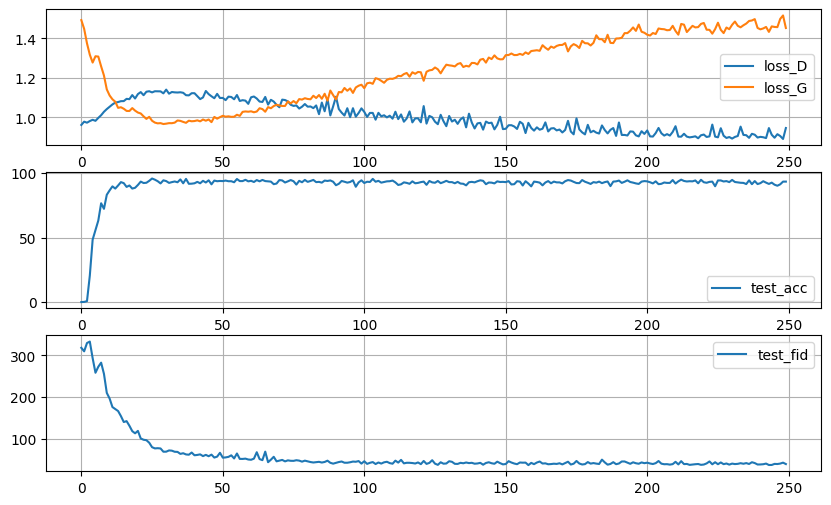

Epoch 251
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9133649, loss_G: 1.8158485, D_x: 0.7679, D_G_z: 0.2560/0.1370
[ 15/151] loss_D: 0.8814398, loss_G: 1.5889719, D_x: 0.8692, D_G_z: 0.2048/0.1749
[ 30/151] loss_D: 0.8939288, loss_G: 1.8463709, D_x: 0.8823, D_G_z: 0.2674/0.1302
[ 45/151] loss_D: 0.9451374, loss_G: 1.4348865, D_x: 0.8816, D_G_z: 0.3284/0.2084
[ 60/151] loss_D: 0.9142028, loss_G: 1.4217033, D_x: 0.7524, D_G_z: 0.1241/0.2142
[ 75/151] loss_D: 0.8947603, loss_G: 1.6024714, D_x: 0.8701, D_G_z: 0.2743/0.1685
[ 90/151] loss_D: 0.8813980, loss_G: 1.4993882, D_x: 0.8560, D_G_z: 0.1985/0.1898
[105/151] loss_D: 0.8800559, loss_G: 1.2314770, D_x: 0.8065, D_G_z: 0.2287/0.2654
[120/151] loss_D: 0.8629605, loss_G: 1.3052254, D_x: 0.8387, D_G_z: 0.2204/0.2426
[135/151] loss_D: 0.8910115, loss_G: 1.2832377, D_x: 0.7817, D_G_z: 0.1357/0.2486
[150/151] loss_D: 1.2393308, loss_G: 1.8638659, D_x: 0.9282, D_G_z: 0.5585/0.1260


[ 90/151] loss_D: 0.8893738, loss_G: 1.8514636, D_x: 0.8776, D_G_z: 0.2642/0.1255
[105/151] loss_D: 0.8868989, loss_G: 1.2158847, D_x: 0.7591, D_G_z: 0.1772/0.2672
[120/151] loss_D: 0.9291152, loss_G: 1.3913171, D_x: 0.7168, D_G_z: 0.1581/0.2176
[135/151] loss_D: 0.9615647, loss_G: 1.5560343, D_x: 0.8603, D_G_z: 0.3624/0.1766
[150/151] loss_D: 1.0664032, loss_G: 2.0703940, D_x: 0.7856, D_G_z: 0.4457/0.0972
Train | loss_D: 0.89566386, loss_G: 1.50335860
Test  | accuracy: 94.50%, FID: 38.7724

Epoch 259
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9926746, loss_G: 1.0013527, D_x: 0.6542, D_G_z: 0.1013/0.3486
[ 15/151] loss_D: 1.0061167, loss_G: 1.7433844, D_x: 0.8753, D_G_z: 0.3942/0.1459
[ 30/151] loss_D: 0.8944420, loss_G: 1.0932748, D_x: 0.7715, D_G_z: 0.1503/0.3046
[ 45/151] loss_D: 0.8683074, loss_G: 1.5472443, D_x: 0.8409, D_G_z: 0.1812/0.1820
[ 60/151] loss_D: 0.9419379, loss_G: 2.1530230, D_x: 0.8161, D_G_z: 0.3245/0.

[  0/151] loss_D: 0.8665174, loss_G: 1.6975180, D_x: 0.8364, D_G_z: 0.1932/0.1541
[ 15/151] loss_D: 0.8751799, loss_G: 1.2559338, D_x: 0.8525, D_G_z: 0.2435/0.2595
[ 30/151] loss_D: 0.8950359, loss_G: 1.8510256, D_x: 0.8962, D_G_z: 0.2533/0.1273
[ 45/151] loss_D: 0.9280463, loss_G: 1.2153885, D_x: 0.7290, D_G_z: 0.1351/0.2649
[ 60/151] loss_D: 0.8913093, loss_G: 1.5454972, D_x: 0.8477, D_G_z: 0.2419/0.1856
[ 75/151] loss_D: 0.8779682, loss_G: 1.4589435, D_x: 0.8288, D_G_z: 0.1858/0.2005
[ 90/151] loss_D: 0.8983256, loss_G: 1.1392143, D_x: 0.7854, D_G_z: 0.2201/0.2943
[105/151] loss_D: 0.8700861, loss_G: 1.6408617, D_x: 0.8589, D_G_z: 0.1777/0.1611
[120/151] loss_D: 0.8947363, loss_G: 1.4118382, D_x: 0.7841, D_G_z: 0.1403/0.2144
[135/151] loss_D: 0.8983010, loss_G: 1.7903025, D_x: 0.8365, D_G_z: 0.2482/0.1390
[150/151] loss_D: 0.9095894, loss_G: 1.3372613, D_x: 0.7622, D_G_z: 0.2318/0.2330
Train | loss_D: 0.89395899, loss_G: 1.47770190
Test  | accuracy: 92.40%, FID: 38.9467

Epoch 267
-

[120/151] loss_D: 0.8838319, loss_G: 1.4763405, D_x: 0.8387, D_G_z: 0.2103/0.1965
[135/151] loss_D: 0.9047291, loss_G: 1.7145653, D_x: 0.9018, D_G_z: 0.2652/0.1490
[150/151] loss_D: 0.9030683, loss_G: 0.9517848, D_x: 0.7783, D_G_z: 0.1933/0.3641
Train | loss_D: 0.90652931, loss_G: 1.49535751
Test  | accuracy: 92.20%, FID: 44.0641

Epoch 274
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8794228, loss_G: 1.4423575, D_x: 0.8935, D_G_z: 0.2563/0.2037
[ 15/151] loss_D: 0.8945735, loss_G: 1.6246264, D_x: 0.8961, D_G_z: 0.2065/0.1676
[ 30/151] loss_D: 0.9175840, loss_G: 2.0173025, D_x: 0.9058, D_G_z: 0.3039/0.1071
[ 45/151] loss_D: 0.8877554, loss_G: 1.3574400, D_x: 0.8549, D_G_z: 0.2416/0.2282
[ 60/151] loss_D: 0.8542719, loss_G: 1.4435859, D_x: 0.8301, D_G_z: 0.1835/0.2015
[ 75/151] loss_D: 0.8447815, loss_G: 1.2953951, D_x: 0.8089, D_G_z: 0.1658/0.2440
[ 90/151] loss_D: 0.9048070, loss_G: 1.7506950, D_x: 0.8958, D_G_z: 0.2476/0.

[ 30/151] loss_D: 0.8752114, loss_G: 1.6460981, D_x: 0.8747, D_G_z: 0.2569/0.1655
[ 45/151] loss_D: 0.8894342, loss_G: 1.4219446, D_x: 0.7645, D_G_z: 0.1699/0.2123
[ 60/151] loss_D: 0.8840693, loss_G: 1.5360544, D_x: 0.8670, D_G_z: 0.2273/0.1826
[ 75/151] loss_D: 0.9985020, loss_G: 1.1580267, D_x: 0.6557, D_G_z: 0.1086/0.2906
[ 90/151] loss_D: 0.8866916, loss_G: 1.2734567, D_x: 0.8012, D_G_z: 0.1462/0.2525
[105/151] loss_D: 0.8758219, loss_G: 1.5586112, D_x: 0.8747, D_G_z: 0.2526/0.1807
[120/151] loss_D: 0.8825807, loss_G: 1.0549452, D_x: 0.8447, D_G_z: 0.2462/0.3273
[135/151] loss_D: 0.8849586, loss_G: 1.6948020, D_x: 0.8892, D_G_z: 0.2037/0.1524
[150/151] loss_D: 0.8835164, loss_G: 1.4671251, D_x: 0.8002, D_G_z: 0.1536/0.1951
Train | loss_D: 0.89445609, loss_G: 1.56212282
Test  | accuracy: 90.50%, FID: 46.3721

Epoch 282
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9392321, loss_G: 1.7582833, D_x: 0.9115, D_G_z: 0.2927/0.

[150/151] loss_D: 0.8989435, loss_G: 1.7033348, D_x: 0.7275, D_G_z: 0.1251/0.1489
Train | loss_D: 0.88462746, loss_G: 1.49372566
Test  | accuracy: 93.60%, FID: 41.7978

Epoch 289
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8548660, loss_G: 1.1200192, D_x: 0.8441, D_G_z: 0.1532/0.3040
[ 15/151] loss_D: 0.9054831, loss_G: 1.4784055, D_x: 0.8262, D_G_z: 0.2524/0.1924
[ 30/151] loss_D: 0.8986827, loss_G: 1.3660649, D_x: 0.7650, D_G_z: 0.1459/0.2231
[ 45/151] loss_D: 0.8996045, loss_G: 1.2204802, D_x: 0.7632, D_G_z: 0.1706/0.2702
[ 60/151] loss_D: 0.8679559, loss_G: 1.7234595, D_x: 0.8090, D_G_z: 0.1465/0.1462
[ 75/151] loss_D: 0.8703718, loss_G: 1.5118444, D_x: 0.8252, D_G_z: 0.2009/0.1855
[ 90/151] loss_D: 0.8807913, loss_G: 1.8336657, D_x: 0.8128, D_G_z: 0.1874/0.1326
[105/151] loss_D: 0.8984154, loss_G: 1.7724550, D_x: 0.8396, D_G_z: 0.2634/0.1384
[120/151] loss_D: 0.8537468, loss_G: 1.3437235, D_x: 0.8454, D_G_z: 0.1848/0.

[ 60/151] loss_D: 0.8574644, loss_G: 1.6939822, D_x: 0.8411, D_G_z: 0.1562/0.1484
[ 75/151] loss_D: 0.8691285, loss_G: 1.4045731, D_x: 0.7719, D_G_z: 0.1679/0.2124
[ 90/151] loss_D: 0.8687608, loss_G: 1.3827686, D_x: 0.8206, D_G_z: 0.2273/0.2192
[105/151] loss_D: 0.8617622, loss_G: 1.4850372, D_x: 0.8070, D_G_z: 0.1916/0.1939
[120/151] loss_D: 0.9027817, loss_G: 1.0894846, D_x: 0.7536, D_G_z: 0.1726/0.3134
[135/151] loss_D: 0.8801770, loss_G: 1.3663143, D_x: 0.8627, D_G_z: 0.1956/0.2239
[150/151] loss_D: 0.8668162, loss_G: 1.6811618, D_x: 0.8404, D_G_z: 0.2422/0.1496
Train | loss_D: 0.88343626, loss_G: 1.48509943
Test  | accuracy: 96.40%, FID: 38.3959

Epoch 297
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8592126, loss_G: 1.4168599, D_x: 0.7759, D_G_z: 0.1600/0.2119
[ 15/151] loss_D: 0.9258253, loss_G: 1.2248063, D_x: 0.8109, D_G_z: 0.3301/0.2670
[ 30/151] loss_D: 0.8665828, loss_G: 1.7053959, D_x: 0.8334, D_G_z: 0.1718/0.

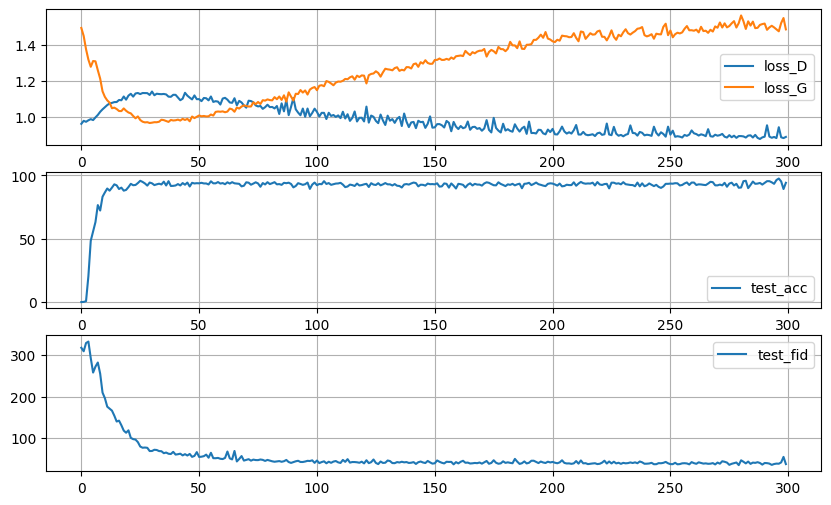

Epoch 301
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.9794184, loss_G: 2.2171164, D_x: 0.9175, D_G_z: 0.3608/0.0851
[ 15/151] loss_D: 0.8926612, loss_G: 1.7417560, D_x: 0.8290, D_G_z: 0.2786/0.1437
[ 30/151] loss_D: 0.8936306, loss_G: 1.5494467, D_x: 0.8604, D_G_z: 0.2177/0.1792
[ 45/151] loss_D: 0.9053717, loss_G: 1.2439986, D_x: 0.7503, D_G_z: 0.1323/0.2555
[ 60/151] loss_D: 0.8787327, loss_G: 1.4905198, D_x: 0.8011, D_G_z: 0.1853/0.1931
[ 75/151] loss_D: 0.8577168, loss_G: 1.3486489, D_x: 0.8744, D_G_z: 0.1862/0.2323
[ 90/151] loss_D: 0.8755504, loss_G: 1.2287169, D_x: 0.7895, D_G_z: 0.1922/0.2596
[105/151] loss_D: 0.8663601, loss_G: 1.5287330, D_x: 0.8136, D_G_z: 0.1782/0.1875
[120/151] loss_D: 0.8829877, loss_G: 1.5405424, D_x: 0.8919, D_G_z: 0.1988/0.1855
[135/151] loss_D: 0.9038345, loss_G: 1.3702648, D_x: 0.7681, D_G_z: 0.1436/0.2222
[150/151] loss_D: 0.8722138, loss_G: 1.6421237, D_x: 0.7986, D_G_z: 0.2197/0.1684


[ 90/151] loss_D: 0.9273670, loss_G: 1.6714678, D_x: 0.8706, D_G_z: 0.2487/0.1592
[105/151] loss_D: 0.9149151, loss_G: 1.7569735, D_x: 0.8888, D_G_z: 0.2892/0.1412
[120/151] loss_D: 0.8856293, loss_G: 1.5570111, D_x: 0.7813, D_G_z: 0.1621/0.1814
[135/151] loss_D: 0.8884206, loss_G: 1.6147524, D_x: 0.8826, D_G_z: 0.2552/0.1655
[150/151] loss_D: 0.8658047, loss_G: 1.7970455, D_x: 0.8716, D_G_z: 0.1929/0.1323
Train | loss_D: 0.88665742, loss_G: 1.51974332
Test  | accuracy: 94.30%, FID: 43.2950

Epoch 309
---------------------------------------------------------------------------------------
[  0/151] loss_D: 0.8637415, loss_G: 1.6468959, D_x: 0.8763, D_G_z: 0.1893/0.1573
[ 15/151] loss_D: 0.8591313, loss_G: 1.7820492, D_x: 0.8540, D_G_z: 0.2398/0.1342
[ 30/151] loss_D: 0.9081177, loss_G: 1.5858382, D_x: 0.8590, D_G_z: 0.2614/0.1705
[ 45/151] loss_D: 0.9546876, loss_G: 1.8624903, D_x: 0.8808, D_G_z: 0.2992/0.1227
[ 60/151] loss_D: 0.9344978, loss_G: 1.9151472, D_x: 0.9137, D_G_z: 0.3370/0.

KeyboardInterrupt: 

In [24]:
num_epochs = 600

for epoch in range(1, num_epochs+1):
    ee = len(record['loss_D'])+1
    print(f"Epoch {ee}\n---------------------------------------------------------------------------------------")
    
    loss_D, loss_G = train_loop()
    test_acc, test_fid = test_loop('gan_output')
    
    record['loss_G'].append(loss_G.item())
    record['loss_D'].append(loss_D.item())
    record['test_acc'].append(test_acc)
    record['test_fid'].append(test_fid)

    if (ee%50 == 0):
        show_plot(record)
        torch.save({
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict(),
            }, f'discriminator_{ee}.pth')
        torch.save({
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            }, f'generator_{ee}.pth')
        np.savez(f'record_{ee}', loss_G=np.array(record['loss_G']), loss_D=np.array(record['loss_D']),
                 test_acc=np.array(record['test_acc']), test_fid=np.array(record['test_fid']))

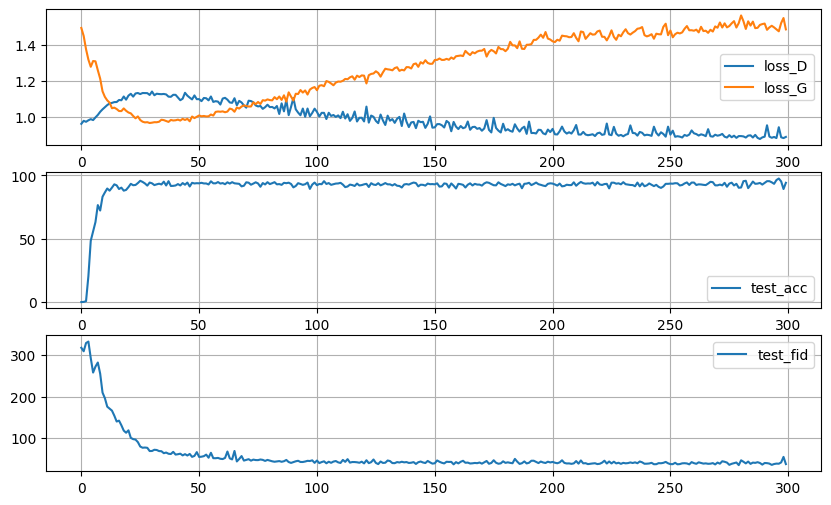

In [8]:
show_plot(record)

In [34]:
torch.save(generator, 'generator_v2.pth')
torch.save(discriminator, 'discriminator_v2.pth')
np.savez('record_v2', loss_G=np.array(record['loss_G']), loss_D=np.array(record['loss_D']), 
         test_acc=np.array(record['test_acc']), test_fid=np.array(record['test_fid']))

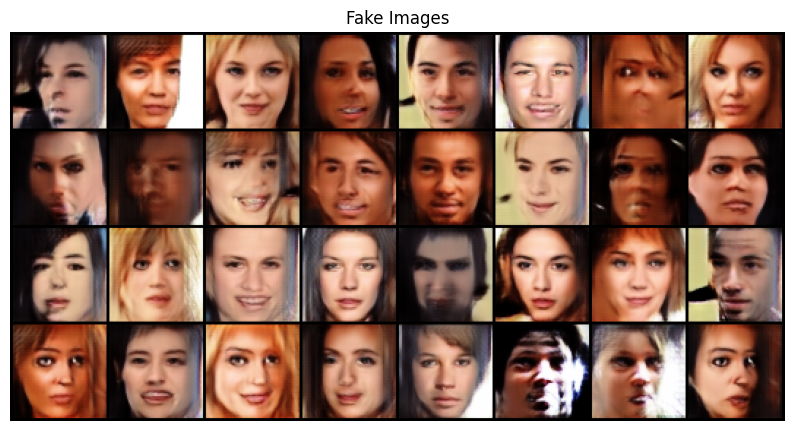

In [77]:
a = torch.randn(32, 100, 1, 1, device=device)
generator.eval()
with torch.no_grad():
    b = generator(a).detach().cpu()
    c = (vutils.make_grid(b, nrow=8, padding=2, normalize=True))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(c,(1,2,0)))
plt.show()

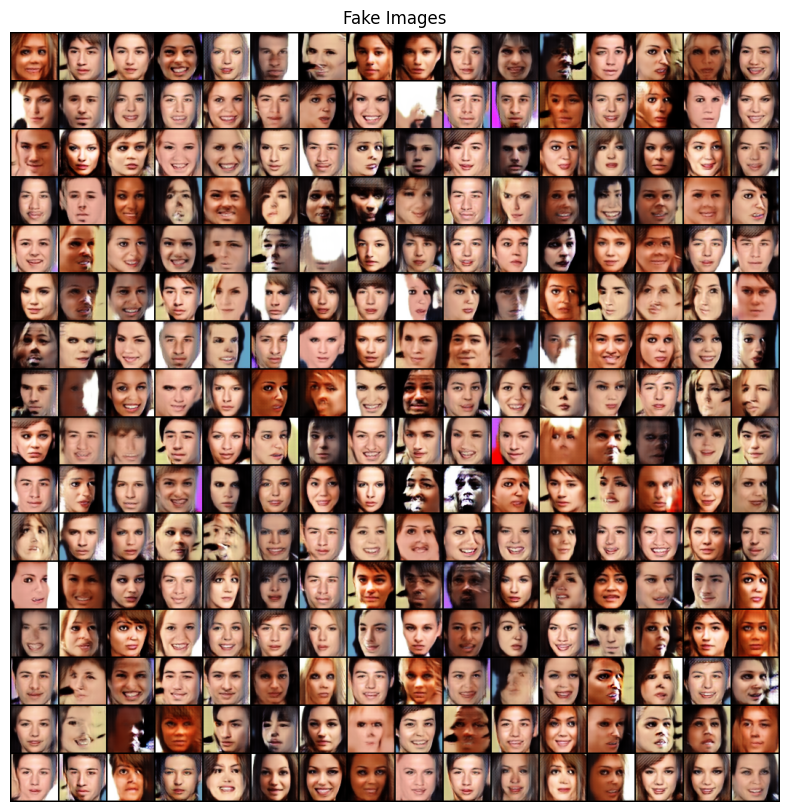

In [80]:
a = torch.randn(256, 100, 1, 1, device=device)
with torch.no_grad():
    b = generator(a).detach().cpu()
    c = (vutils.make_grid(b, nrow=16, padding=2, normalize=True))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(c,(1,2,0)))
plt.show()